# Imports


In [6]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import random
import sys
import os
import re


from ANN_Levenshtein import LevenshteinIndex

# Load Data


In [ ]:
data = pd.read_csv('Data/IMK품목마스터.txt', delimiter='\t', dtype=str)
data.head(2)

In [25]:
data.shape

(2538466, 13)

In [26]:
data['description'] = data[['영문품명', '한글품명', '규격', '모델명', '제조원명']].astype(str).agg(" ".join, axis=1)
data['label'] = data['품목코드']

In [27]:
data = data[['label', 'description']]

# Preprocess


In [28]:
def preprocessing(text):
    def remove_dup(t):
        sp_str = t.split()
        return " ".join(sorted(set(sp_str), key=sp_str.index))

    if not isinstance(text, str):
        text = str(text)
    
    # text = text.lower()  # 소문자로 변환

    # 패턴 제거: (주), (유)
    text = re.sub(r'\(주\)|\(유\)', '', text)

    # 특수문자 제거 (온점, 쉼표, 물결표 제외)
    special_chars = r'[()\[\]/#φΦØø￠★@%※□:;"＇，_\-!&+=≥±`\'\"←→↑↓↔↕\\\^]'
    text = re.sub(special_chars, ' ', text)

    # 숫자 사이에 있는 .(소숫점 표시) ,(천의 자리 표시), ~(범위 표시)는 유지, 나머지 .,~ 삭제
    text = re.sub(r'(?<!\d)[.,~]|[.,~](?!\d)', ' ', text)

    # 숫자 사이의 ~만 유지
    text = re.sub(r'\s*~\s*', '~', text)  # ~ 앞뒤의 공백 삭제 (ex. 10~100, 10 ~ 100 둘 다 가능하게)
    text = re.sub(r'(?<!\d)~|~(?!\d)', ' ', text)  # ~ 앞뒤가 숫자가 아니면 삭제


    # 불필요 문구 제거 (공통 패턴)
    common_patterns = [
        '세부구성 이미지\s?참고','첨부\s?이미지\s?참고','이미지\s?참조','요청사항\s?참조','명판\s?참조','물류이용불가 품목',
        '일반화물택배발송','주문수입품목으로 교환\s?반품\s?불가','주문제작품으로 교환\s?반품\s?불가','교환 및 반품\s?불가',
        '규격\s?참조','첨부\s?참조','규격\s?참고','도면\s?참조','사양서\s?참조','주문시\s?사이즈\s?기재','추가발주불가',
        '재고\s?문의\s?주세요','주문전\s?재고\s?확인\s?바랍니다','첨부파일 참조','참조s?제작s?할s?것','교환\s?반품\s?불가',
        '도면rev \d+참조','도묜참조','구매\s?시방서참조','구매시방참조','사진s?참고','사양서s?참고','사영서s?참고',
        '도면\s?참고','사양\s?참고','상세정보 첨부참고','상세정보\s?참고','첨부 참고'
    ]
    text = re.sub(r'|'.join(common_patterns), "", text)
    
    # 재고 관련 문구 제거
    inventory_patterns = [
        r"재고 없을\s?시 \d+일\s?소요", r"재고 미보유시 \d+일\s?소요", r'재고\s?소진\s?시 납기 \d+일',
        r'재고 소진\s?시 공급\s?불가', r'재고 소진\s?시 납품\s?불가', r'재고 소진\s?시 공급\s?불가\s?상품',
        r'재고 소진\s?시 \d+일 소요', r'국내 재고 소진\s?시 납기 약\s?\d+개월 소요',
        r'재고 소진\s?시 표준납기\s?\d+일 소요', r'재고 소진\s?시 최소주문수량 적용상품',
        r'재고 없을\s?때 \d+일\s?소요', r'재고 없을\s?시 표준납기 \d+일\s?소요',
        r'재고 없을\s?시 제작\s?납기 \d+일\s?소요', r'수입품목으로 재고 없을\s?시 납기 \d+\s?\d+일\s?소요',
        r'재고 미보유\s?시 \d+일 이상 소요', r'재고 미보유\s?시 납기\s?\d+일',
        r'재고\s?소진\s?시 발주\s?취소 가능성', r'재고 보유\s?시 \d+일 소요',
        r'재고s?소진 후 구매s?불가', r'재고 보유\s?시 \d+일\s?이내',
        r'재고 미보유\s?시 표준납기 \d+일\s?소요'
    ]
    text = re.sub(r'|'.join(inventory_patterns), "", text)
    
    # 추가적 문구 제거
    remove_terms = ['인쇄없음', '시중품', '주식회사', '유한회사']
    text = re.sub(r'|'.join(remove_terms), "", text)

    # 텍스트 치환
    text = text.replace('nan', ' ')
    text = text.replace('| ', ' ').replace(' |', ' ').replace('||', ' ')
    text = re.sub(r'[xX×*＊]', 'x', text)  # 곱하기 기호 통일
    text = text.replace('ℓ', 'l')  # 리터 기호 통일

    # 한자 제거
    text = re.sub(r'[\u4E00-\u9FFF]', '', text)

    # 중복된 단어 제거
    text = remove_dup(text)
    
    # 여러 공백을 하나의 공백으로 변환
    text = re.sub(r'\s+', ' ', text).strip()

    return text

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid e

In [29]:
data['description'] = data['description'].map(preprocessing)


In [30]:
data.head(2)

,label,description
0,1000000800,Fly Swatter 파리채 L520mm
1,1000002100,Insecticide 살충제 500ml 수성에어졸 무향 파리 모기등의살충제 안전기준...


In [37]:
data.to_csv('Data/IMK_master.txt', sep='\t', index=False)

In [28]:
strings = data['description'].astype(str)

In [32]:
lengths = [len(string) for string in strings]
print(lengths[:10])

[22, 60, 78, 62, 53, 30, 91, 187, 162, 55]


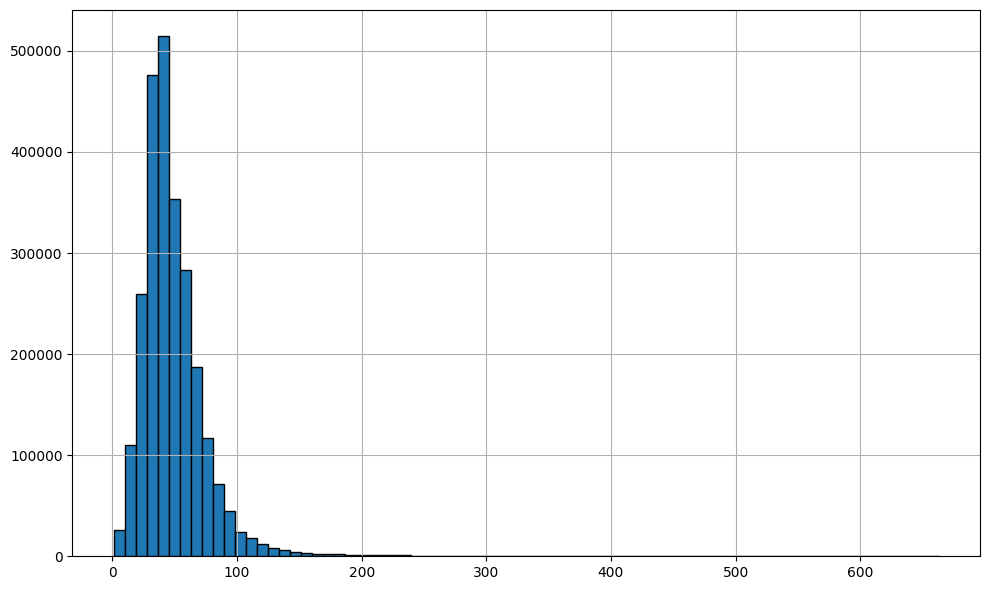

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=75, edgecolor='black')
# plt.title("Distribution of String Lengths in IMK master")
# plt.xlabel("String Length")
# plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
np.mean(lengths)

np.float64(48.339612978862036)

# Build Index


### tree_num=10


In [42]:
data = pd.read_csv('Data/IMK_master.txt', delimiter='\t', dtype=str)
# data = pd.read_csv('Data/Random_strings_0.1K.txt', header=None)

In [43]:
data.head(2)

,label,description
0,1000000800,Fly Swatter 파리채 L520mm
1,1000002100,Insecticide 살충제 500ml 수성에어졸 무향 파리 모기등의살충제 안전기준...


In [44]:
print(len(data))

2538466


In [ ]:
%%time

# Create and configure index
leven_index = LevenshteinIndex(
    num_trees=10,
    num_strings=len(data),
    split_num=200,
    weights=(1, 1, 1)
)


#  80.2 ms for create index

CPU times: total: 0 ns
Wall time: 3.98 ms


In [ ]:
%%time

# Add strings in bulk
leven_index.add_items_bulk(data['description'])

# 4.26 s for len(data) = 2.5M

CPU times: total: 4.28 s
Wall time: 4.32 s


In [ ]:
%%time

# Build index
leven_index.build()

# for num_trees=10, len(data)~2.5M, split_num=200

In [ ]:
%%time

# save
leven_index.save("Models/LevenshteinIndex_IMK_master_10tree.pkl")

In [ ]:
# leven_index = LevenshteinIndex(num_trees=1, num_strings=len(data), split_num=200)
# leven_index.add_items_bulk(data['description'])
# leven_index.load("Models/LevenshteinIndex_1tree_IMK_master.pkl")

In [ ]:
%%time

# Query
query = data['description'][5]
neighbors = leven_index.get_nns_by_string(query, topk=5)

print("Query:", query)
print("Top 5 nearest neighbors:")
for idx in neighbors:
    if idx is not None:
        print(f"{idx}, {leven_index.get_strings()[idx]}")

Query: F Killer 에프킬라 500ml 킨 에스씨존슨코리아
Top 5 nearest neighbors:
5, F Killer 에프킬라 500ml 킨 에스씨존슨코리아
761, F Killer 에프킬라 500ml 무향 에스씨존슨코리아
174, 육각너트 SUS M27 반도호이스트크레인
282, Spring Cleaner 스프링청소기 30M KSU30M 공성기계
754, Complex Fertilizer 복합비료 동부화학


### tree_num = 100


In [ ]:
%%time

# Create index 
leven_index = LevenshteinIndex(num_trees=100, num_strings=len(data), split_num=200, weights=(1,1,1))


#  80.2 ms for create index

CPU times: total: 0 ns
Wall time: 3.98 ms


In [ ]:
%%time

# add data
leven_index.add_items_bulk(data['description'])

# 4.26 s for len(data) = 2.5M

CPU times: total: 4.28 s
Wall time: 4.32 s


In [ ]:
%%time

# build index
leven_index.build()

# for num_trees=10, len(data)~2.5M, split_num=200

In [ ]:
%%time

# save
leven_index.save("Models/LevenshteinIndex_IMK_master_10tree.pkl")

In [ ]:
# leven_index = LevenshteinIndex(num_trees=1, num_strings=len(data), split_num=200)
# leven_index.add_items_bulk(data['description'])
# leven_index.load("Models/LevenshteinIndex_1tree_IMK_master.pkl")

In [ ]:
%%time

# Query
query = data['description'][5]
neighbors = leven_index.get_nns_by_string(query, topk=5)

print("Query:", query)
print("Top 5 nearest neighbors:")
for idx in neighbors:
    print(f"{idx}, {leven_index.get_strings()[idx]}")

Query: F Killer 에프킬라 500ml 킨 에스씨존슨코리아
Top 5 nearest neighbors:
5, F Killer 에프킬라 500ml 킨 에스씨존슨코리아
761, F Killer 에프킬라 500ml 무향 에스씨존슨코리아
174, 육각너트 SUS M27 반도호이스트크레인
282, Spring Cleaner 스프링청소기 30M KSU30M 공성기계
754, Complex Fertilizer 복합비료 동부화학


# Search ALL


In [ ]:
from rapidfuzz.distance import Levenshtein
import unicodedata
from rapidfuzz import fuzz
# Hangul Decomposition function using unicodedata
def decompose_hangul(text, *args, **kwargs):
    decomposed = ''
    for char in text:
        if '가' <= char <= '힣':
            # Hangul syllables range: decompose
            decomposed += unicodedata.normalize('NFD', char)
        else:
            decomposed += char
    return decomposed

In [ ]:
%%time

query = data['description'][5]

# Add a new column with fuzz.ratio distances to the query string
data['sim'] = data['description'].map(lambda x: fuzz.ratio(query, x, processor=decompose_hangul))


# Sort and take top 5
top5 = data.sort_values('sim', ascending=False).head(5)  # Higher ratio = more similar

# Display
print("Query:", query)
print("Top 5 nearest neighbors:")
for _, row in top5.iterrows():
    print(f"Index: {row.name}, Distance: {row['sim']}, Text: {row['description']}")

Query: F Killer 에프킬라 500ml 킨 에스씨존슨코리아
Top 5 nearest neighbors:
Index: 5, Distance: 0, Text: F Killer 에프킬라 500ml 킨 에스씨존슨코리아
Index: 761, Distance: 5, Text: F Killer 에프킬라 500ml 무향 에스씨존슨코리아
Index: 108, Distance: 36, Text: Set Collar 세트칼라 SSCSPJ30 12 MISUMI
Index: 319, Distance: 36, Text: Ball Screw 성광테크 볼스크류
Index: 542, Distance: 36, Text: Side Roller 사이드롤러 Peek 다일엔지니어링


In [ ]:
%%time

query = data['description'][5]

# Add a new column with fuzz.ratio distances to the query string
data['sim'] = data['description'].map(lambda x: Levenshtein.distance(query, x, processor=decompose_hangul))


# Sort and take top 5
top5 = data.sort_values('sim', ascending=False).head(5)  # Higher ratio = more similar

# Display
print("Query:", query)
print("Top 5 nearest neighbors:")
for _, row in top5.iterrows():
    print(f"Index: {row.name}, Distance: {row['sim']}, Text: {row['description']}")